# Extracting daily routines from time diares data

## 0. Import libreries 

In [1]:
# !pip install matplotlib==3.6.3
# !pip install networkx==3.0

In [2]:
# Utils
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


# Data processing
from data_processing import sequences_by_time_intervals, sequences_by_transitions, time_and_transitions

# Network 
import networkx as nx
from my_network_functions import create_network

# Visualisation
import plotly.express as px
from my_network_functions import draw_network, draw_all_networks


## 1. Read and inspect the dataset

In [3]:
df = pd.read_stata('.\DATA\seq_tot_clean_2023\seq_tot_clean_2023.dta')
df.head(5)

,id,MM_not,GG_not,hh_not,mm_not,week,where,withw,mood,sex,...,whatrr,order,order1,day,GG1,sample,sede,sel,_merge,dover1
0,0.0,11.0,25.0,9.0,30.0,Thursday,Home Apartment Room,Alone,4.0,Female,...,Selfcare/husework,09:30,09,Thursday,25.0,2020,NaN,0.0,matched (3),Home Apartment Room
1,0.0,11.0,19.0,9.0,30.0,Friday,Home Apartment Room,Alone,4.0,Female,...,Selfcare/husework,09:30,09,Friday,19.0,2020,NaN,0.0,matched (3),Home Apartment Room
2,0.0,11.0,26.0,15.0,30.0,Friday,Home Apartment Room,Alone,3.0,Female,...,Free time,15:30,15,Friday,26.0,2020,NaN,0.0,matched (3),Home Apartment Room
3,0.0,11.0,24.0,15.0,0.0,Wednesday,Home Apartment Room,Alone,4.0,Female,...,Study,15:00,15,Wednesday,24.0,2020,NaN,0.0,matched (3),Home Apartment Room
4,0.0,11.0,23.0,4.0,0.0,Tuesday,Home Apartment Room,Alone,4.0,Female,...,Sleeping,04:00,04,Monday,22.0,2020,NaN,0.0,matched (3),Home Apartment Room


Explore columns dtypes

In [4]:
# Columns
print('COLUMNS')
print(df.dtypes)

COLUMNS
id                    float64
MM_not                float32
GG_not                float32
hh_not                float32
mm_not                float32
week                 category
where                category
withw                category
mood                 category
sex                  category
department           category
Extraversion          float32
Agreeableness         float32
Conscientiousness     float32
Neuroticism           float32
Openness              float32
degree2              category
misdays               float64
misval                float64
what                 category
whatrr               category
order                category
order1               category
day                  category
GG1                   float32
sample               category
sede                 category
sel                   float64
_merge               category
dover1               category
dtype: object


In [5]:
df2 = df
# fix the names of the time-related columns
d = {'sample': 'year', 'MM_not': 'month', 'GG_not': 'day',
     'hh_not': 'hour', 'mm_not': 'minute'}

#drop some columns, rename them, modify column types
df2 = df2.drop(columns=['day', 'week', 'misdays', 'misval', 'whatrr', 'order1',
               'GG1', 'sel', '_merge']).rename(columns=d).astype({'year': 'int'})

df2['datetime'] = pd.to_datetime(df2[list(d.values())])

# sort values by datetime
df2 = df2.sort_values(['id', 'datetime'])

# check first rows
df2.head(5)

,id,month,day,hour,minute,where,withw,mood,sex,department,...,Conscientiousness,Neuroticism,Openness,degree2,what,order,year,sede,dover1,datetime
204,0.0,11.0,14.0,5.0,0.0,Home Apartment Room,Alone,Happy,Female,Engineering and Applied Sciences,...,93.75,50.0,87.5,MA/PhD,Sleeping,05:00,2020,NaN,Home Apartment Room,2020-11-14 05:00:00
448,0.0,11.0,14.0,5.0,30.0,Home Apartment Room,Alone,Happy,Female,Engineering and Applied Sciences,...,93.75,50.0,87.5,MA/PhD,Sleeping,05:30,2020,NaN,Home Apartment Room,2020-11-14 05:30:00
605,0.0,11.0,14.0,6.0,0.0,Home Apartment Room,Alone,Happy,Female,Engineering and Applied Sciences,...,93.75,50.0,87.5,MA/PhD,Sleeping,06:00,2020,NaN,Home Apartment Room,2020-11-14 06:00:00
424,0.0,11.0,14.0,6.0,30.0,Home Apartment Room,Alone,Happy,Female,Engineering and Applied Sciences,...,93.75,50.0,87.5,MA/PhD,Sleeping,06:30,2020,NaN,Home Apartment Room,2020-11-14 06:30:00
423,0.0,11.0,14.0,7.0,0.0,Home Apartment Room,Alone,Happy,Female,Engineering and Applied Sciences,...,93.75,50.0,87.5,MA/PhD,Sleeping,07:00,2020,NaN,Home Apartment Room,2020-11-14 07:00:00


In [6]:
### [Same ID, Different YEAR] != Same Person --> We need to fix it! <---

# change columns type
df2 = df2.astype({'year': 'string', 'id':'string'})

# define a new ID
df2['new_id'] = (df2['year'] + df2['id']).astype(float).astype(int)

# transform it to numeric
n = 0
for i in df2['new_id'].unique():
    df2.loc[df2['new_id'] == i, 'new_id'] = n
    n += 1

# drop initial id column, save new IDs.
df2 = df2.drop(columns=['id']).rename(columns={'new_id':'id'})
    
print('There are', len(df2.id.unique()), 'subjects')

There are 247 subjects


Let's create a new dataframe, `info`, containing information about subjects: 
* New assigned `id`, `sex`.
* The experiment in which they participated, given by the `year` column.
* If data were collected in _2018_, then `sede` is defined. On the contrary, if the subject participated to the _2020_ data collection, then `department` information was registered. Hence, in the following script I created a new column `department_sede` reporting either one or the other information about university campus area. 
* Big Five personality traits: `extraversion`, `agreeableness`, `conscientiousness`, `neuroticism`, `openness`

In [7]:
info = pd.DataFrame(columns=['id', 'year', 'sex', 'department', 'sede', 'extraversion',
                    'agreeableness', 'conscientiousness', 'neuroticism', 'openness'])


df_grouped = df2.groupby('id')
for group in df_grouped:
    data = group[1]
    to_add = [group[0],
              data.iloc[0]['year'],
              data.iloc[0]['sex'],
              data.iloc[0]['department'],
              data.iloc[0]['sede'],
              data.iloc[0]['Extraversion'],
              data.iloc[0]['Agreeableness'],
              data.iloc[0]['Conscientiousness'],
              data.iloc[0]['Neuroticism'],
              data.iloc[0]['Openness']]

    info.loc[len(info)] = to_add

# combine department and sede columns
# info['department_sede'] = info['department'].fillna(info['sede'])
# info

info['sede202']=info['department']
info['sede202'] = info['sede202'].fillna("0")

label_dict = {
    'Business/economics': 'Centro',  
    'Engineering and Applied Sciences': 'Collina',
    'Humanities': 'Centro',
    'International Relations and Public Administration' : 'Centro',
    'Law' : 'Centro',
    'Medicine and veterinary medicine' : 'Rovereto',
    'Natural Sciences' : 'Collina',
    'Social Sciences' : 'Centro',
    '0': np.nan,
    }
info['sede202'] = info['sede202'].apply( lambda x : label_dict[x])

info['department_sede'] = info['sede202'].fillna(info['sede'])
info=info.drop(['department', 'sede202', 'sede'], axis=1)

label_dict = {
    'Centro': 'Centro',  
    'Collina': 'Collina',
    'Rovereto': 'Centro',
    }
info['department_sede'] = info['department_sede'].apply( lambda x : label_dict[x])
info

,id,year,sex,extraversion,agreeableness,conscientiousness,neuroticism,openness,department_sede
0,0,2020,Female,68.75,87.50,93.75,50.0,87.50,Collina
1,1,2018,Male,6.00,7.00,7.00,8.0,6.00,Centro
2,2,2020,Female,100.00,100.00,31.25,75.0,75.00,Centro
3,3,2020,Male,31.25,56.25,87.50,62.5,81.25,Centro
4,4,2018,Male,5.00,6.00,8.00,8.0,5.00,Centro
...,...,...,...,...,...,...,...,...,...
242,242,2018,Female,9.00,8.00,9.00,3.0,6.00,Collina
243,243,2018,Male,5.00,9.00,9.00,5.0,6.00,Centro
244,244,2018,Male,8.00,6.00,7.00,7.0,10.00,Collina
245,245,2018,Male,6.00,4.00,8.00,8.0,8.00,Centro


As can be seen, personality traits were measured on different scales based on the year. Let's standardize them as T points (mean=$50$, standard deviation = $10$).

In [8]:
# # Select the columns to be standardized to the same scale
# columns_to_standardize = ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness']

# # Standardize the selected columns
# scaler = StandardScaler()
# for i in ['2018', '2020']:
#     info.loc[info['year'] == i, columns_to_standardize] = scaler.fit_transform(info.loc[info['year'] == i, columns_to_standardize])
#     # Rescale the standardized columns to have mean=50 and standard deviation=10
#     info.loc[info['year'] == i, columns_to_standardize] = info.loc[info['year'] == i, columns_to_standardize] * 10 + 50

# info[columns_to_standardize] = info[columns_to_standardize].round()
# info

# Select the columns to be standardized to the same scale
columns_to_normalize = ['extraversion', 'agreeableness', 'conscientiousness', 'neuroticism', 'openness']

for i in ['2018']:
    info.loc[info['year'] == i, columns_to_normalize] = info.loc[info['year'] == i,columns_to_normalize]/10
for i in ['2020']:
    info.loc[info['year'] == i, columns_to_normalize] = info.loc[info['year'] == i,columns_to_normalize]/100

In [9]:
# remove one ID with NA in traits
id_to_remove = info.loc[info['extraversion'].isna() | info['agreeableness'].isna(
) | info['conscientiousness'].isna() | info['neuroticism'].isna() | info['openness'].isna(), 'id'].values[0]
info = info.loc[info['id'] != id_to_remove]

# do it also in the df2 dataframe
df2 = df2.loc[df2['id'] != id_to_remove]
df2.to_csv('df2.csv', index=False)

In [10]:
info.to_csv('info.csv', index=False)

Let's visualize the sample composition by year, sex and department or sede. 

In [11]:
# Assuming the data is in a pandas DataFrame called 'info'
data = info.groupby(['sex', 'year', 'department_sede']).size().rename("Count").reset_index()

data['pc'] = 100 * data['Count'] / data.groupby(['sex', 'year'])['Count'].transform('sum')

# Create the bar plot with smaller dimensions
fig = px.bar(data, x="year", y="pc", color="sex", barmode='group', text="department_sede", height=600, width=1250)

# Set the title
fig.update_layout(title_text='Number of People by Sex, Year and Department/Campus')

# Show the plot
fig.show()


## 2. Activity Sequence Extraction Methods

In this section, we describe three different approaches for processing time diary data to extract sequences of activities. Each approach offers a unique perspective on organizing and analyzing the data.

* Approach 1: Fixed-Length Sequences with Time Intervals

    To begin, we create sequences of fixed length, specifically 48 elements. The primary consideration for this approach is the time intervals. We establish a reference point in time from which we start counting the intervals. By default, the reference point is set at 5 a.m., which represents the first interval of the day. This approach allows us to segment the activities based on the predefined time intervals, providing a consistent framework for analysis.

* Approach 2: Transition-Based Sequences

    In the second approach, we focus solely on transitions between activities, without considering the time intervals. Similar to the first approach, all sequences start at a specific time interval. This method emphasizes the movement and changes between different activities, disregarding the duration of each activity. It offers insights into activity patterns and preferences based on the transitions observed.

* Approach 3: Combined Time Intervals and Transition Sequences

    The third approach combines both time intervals and transitions between activities, incorporating the advantages of the previous two methods. This approach enables a comprehensive understanding of the data by considering both the time intervals and the transitions between different states. By integrating these two aspects, we gain insights into both the temporal and sequential dimensions of the activity sequences.

By employing these three approaches, we can explore the time diary data from various angles, revealing different aspects and patterns of human activities. Depending on the research objectives and analytical requirements, one or a combination of these approaches can be used to gain valuable insights from the data.

It is recommended to set the parameter `categories` at the beginning of the code for the following functions. This approach facilitates the avoidance of errors by ensuring consistency across functions. For instance, if the parameter is set to a specific value (e.g., 'all') in one function, it should be set to the same value in other related functions as well.

In [12]:
#categories = 'all'
categories = 'general'
# categories = {
#     'new_activities': dict(),
#     'encoding':dict()
# }

### Time

<img src="images/time.png" alt= “” width=70% height=70%>

**Function: sequences_by_time_intervals**

`sequences_by_time_intervals(dataframe, categories='all', start='05:00:00', end='04:30:00')`

The `sequences_by_time_intervals` function extracts sequences from a given dataframe based on time intervals. It takes the following parameters:

1. `dataframe`: The dataframe from which the sequences are extracted. It is important to note that the input dataframe must have at least the following columns: 'id', 'datetime', 'year', 'what', 'where', 'withw', 'mood'.

2. `categories` (optional): This parameter accepts either the string `'all'` or `'general'`. Alternatively, you can provide a dictionary mapping between activities and their preferred encoding. If a dictionary is provided, the values must be strings of length 2.

The function generates sequences by taking into account fixed time intervals. This ensures that all sequences have the same length. By default, all sequences start at 5:00.

Each time interval is encoded with a number, ranging from 1 (representing the interval from 5:00 to 5:30) to 48 (representing the interval from 4:30 to 5:00 of the next day). The encoding allows for consistent representation and analysis of the time intervals in the resulting sequences.

Furthermore, the `sequences_by_time_intervals` function adds two additional columns, `what_code` and `what_next_code`, to the dataframe. These columns contain the encoded values of the activities, which can be used as input for creating a network edgelist or further analysis.

The function is particularly useful for extracting activity sequences from time diary data and preparing them for subsequent analysis, such as network analysis or sequence modeling.

Please note that the function assumes a specific structure of the input dataframe and offers customization options through the `categories` parameter. Ensure that your dataframe meets the required column specifications and consider the available options when utilizing this function for your analysis.


In [13]:
time_intervals = sequences_by_time_intervals(df2, categories)
time_intervals

,id,datetime,year,what,where,withw,mood,time_interval,day,sequence_day,what_code,what_next_code
0,0,2020-11-14 05:00:00,2020,Sleeping,Home Apartment Room,Alone,Happy,1,2020-11-14,2020-11-14,1SL,2SL
1,0,2020-11-14 05:30:00,2020,Sleeping,Home Apartment Room,Alone,Happy,2,2020-11-14,2020-11-14,2SL,3SL
2,0,2020-11-14 06:00:00,2020,Sleeping,Home Apartment Room,Alone,Happy,3,2020-11-14,2020-11-14,3SL,4SL
3,0,2020-11-14 06:30:00,2020,Sleeping,Home Apartment Room,Alone,Happy,4,2020-11-14,2020-11-14,4SL,5SL
4,0,2020-11-14 07:00:00,2020,Sleeping,Home Apartment Room,Alone,Happy,5,2020-11-14,2020-11-14,5SL,6SL
...,...,...,...,...,...,...,...,...,...,...,...,...
170347,246,2018-05-23 02:30:00,2018,Sleeping,Home Apartment Room,Partner,NaN,44,2018-05-23,2018-05-22,44SL,45SL
170348,246,2018-05-23 03:00:00,2018,Sleeping,Home Apartment Room,Partner,NaN,45,2018-05-23,2018-05-22,45SL,46SL
170349,246,2018-05-23 03:30:00,2018,Sleeping,Home Apartment Room,Partner,Sad,46,2018-05-23,2018-05-22,46SL,47SL
170350,246,2018-05-23 04:00:00,2018,Sleeping,Home Apartment Room,Partner,Sad,47,2018-05-23,2018-05-22,47SL,48SL


In [14]:
time_intervals.to_csv('time_intervals.csv', index=False)

#### Model sequences as network

**Function: create_network**

`create_network(df, what_column, what_next_column, categories='all', edge_weight_filter=None, edgelist_to_csv=None, rescale_node_size=True, weekdays=None, random_subject=bool or int, return_color_dict=False, color_dict=None)`

The `create_network` function is used to create a network graph from a given dataframe, based on the specified columns for the source and target of the edges. It offers various customization options for node attributes, edge filtering, and data preprocessing. Here is the detailed description of each parameter:

- `df`: The input dataframe from which the network graph is constructed.

- `what_column`: The column name in the dataframe representing the current activity.

- `what_next_column`: The column name in the dataframe representing the next activity after the current activity.

- `categories` (optional): This parameter accepts three different values:
  - `'all'`: Each unique activity is assigned a random color (dafault)
  - `'general'`: Predefined activity categories (6) are assigned specific colors.
  - A dictionary: You can provide a custom dictionary mapping activities to colors.
  
  Note! The `categories` parameter must be equal to the one set in the previous function (in the following case, `sequences_by_time_interval`).

- `edge_weight_filter` (optional): If specified, edges with weights below this threshold will be filtered out from the resulting network graph.

- `edgelist_to_csv` (optional): If provided with a filename, the function will save the edgelist as a CSV file.

- `rescale_node_size` (optional): Determines whether the node size should be rescaled based on the frequency of activities in the dataframe (for visualization purposes).

- `weekdays` (optional): This parameter accepts two values:
  - `True`: Excludes Saturdays and Sundays from the dataframe.
  - `False`: Includes only Saturdays and Sundays in the dataframe.
  - `None`: All the days of the week.

- `random_subject` (optional): This parameter can take the following values:
  - A specific subject ID (int): Selects data only for the subject with the given ID.
  - `True`: Selects a random subject from the dataframe.
  
- `return_color_dict` (optional): If set to `True`, the function will return a color dictionary used for node coloring.

- `color_dict` (optional): If provided, this dictionary will be used for assigning colors to activities, overriding the default behavior based on the `categories` parameter.

The function performs the following steps:

1. Data preprocessing:
   - If `weekdays` is set to `True`, it adds a 'weekday' column to the dataframe based on the 'sequence_day' column and filters out non-weekday records.
   - If `weekdays` is set to `False`, it filters out weekday records, keeping only Saturdays and Sundays.
   - If `random_subject` is an integer, it filters the dataframe to include only data for that specific subject ID.
   - If `random_subject` is `True`, it randomly selects a subject ID from the dataframe and filters the dataframe to include only data for that subject. It also prints the selected subject ID.

2. Edgelist creation:
   - It creates an edgelist by grouping the dataframe by the `what_column` and `what_next_column` columns and counting the occurrences of each activity transition.
   - If `edge_weight_filter` is specified and `random_subject` is not `True` or an integer, it filters out edges with weights below the specified threshold.

3. Network creation:
   - It creates a directed graph (network) using the edgelist, with nodes representing activities and edges representing transitions between activities.

4. Node attributes:
   - It sets the following attributes for each node in the network:
     - **Label**: The activity label, obtained by removing the prefix from the node name.
     - **Color**: The color assigned to the activity based on the `categories` parameter and the provided or randomly generated color dictionary.
     - **Size**: The size of the node, based on the frequency of the activity in the dataframe. The size can be rescaled using the `rescale_node_size` parameter.
     - **Interval**: The time interval of the activity, extracted from the node name.

5. Saving the edgelist:
   - If `edgelist_to_csv` is specified, the function saves the edgelist as a CSV file with the provided filename.

Finally, the function returns the created network graph object (`G`) and the edgelist dataframe (`counts`). If `return_color_dict` is set to `True`, it also returns the color dictionary used for node coloring.

It is important to note that the function assumes a specific structure of the input dataframe and offers customization options for node attributes and data filtering. Ensure that your dataframe meets the required column specifications and consider the available options when utilizing this function for your network analysis.

In [15]:
G1, edgelist1 = create_network(df=time_intervals,              
                               what_column='what_code',              # source node
                               what_next_column='what_next_code',    # target node
                               categories=categories,                # 'all' or 'general' or dict
                               node_degree_filter=[5, 50],            # remove nodes with degree <= n (first order individual level, second order collective level)
                               rescale_node_size=True,               # node size rescaled fot graphical reasons
                               weekdays=True,                        # True for weekdays, False for weekend, None for whole week
                               random_subject=False,                 # select a random subject or by ID (True / False / ID)
                               edgelist_to_csv='edgelist1.csv',      # save edgelist as csv
                               return_color_dict=False,              # output color palette (default False)
                               color_dict = None,                    # use predefined color palette dict (default None)
                               network_type=1)                       # 1=time intervals, 2=transitions, 3=time_transitions

#### Network visualization

**Function: draw_network**

`draw_network(G, title='', single_subject=False, figsize=(16, 10))`

The `draw_network` function is used to visualize a network graph created using the `create_network` function or any other network graph object (`G`) in a visually appealing manner. It provides options for customizing the appearance of nodes and edges.

**Parameters**

- `G`: The network graph object to be visualized.

- `title` (optional): The title of the network graph.

- `single_subject` (optional, default `False`): If set to `True`, the edge widths are scaled logarithmically to provide emphasis to the edge weights of a single subject. If set to `False`, the edge widths are uniformly distributed.

- `figsize` (optional): The size of the figure in inches (width, height) to control the overall size of the plotted network graph.

**Steps and Output**

1. Calculating edge widths:
   If there are multiple edge weights in the graph, the function calculates a logarithmic scale for the edge widths. The edge weights are scaled logarithmically and then normalized to the desired range. The range of the normalized widths depends on the `single_subject` parameter. If `single_subject` is `True`, the range is [0.3, 1.3]. Otherwise, the range is [0.01, 0.9] (improve readability of the graph).

2. Calculating node positions:
   The function calculates the positions for each node in the network graph based on their assigned interval. The y-coordinate of each node is determined based on the number of nodes within the same interval, ensuring a visually balanced layout.

3. Drawing nodes: the function draws the nodes of the network graph using the specified node colors and sizes.

4. Drawing edges: the function draws the edges of the network graph using the calculated edge widths.

5. Adding legend: the function extracts the node colors from the network graph and creates a legend based on the unique labels and their corresponding colors.

6. Adding title: it adds the specified title to the network graph.

7. Displaying the network graph.

**Notes**

It is important to note that the `draw_network` function relies on the network graph object (`G`) created using the `create_network` function or any other compatible graph object in networkx. Ensure that you have generated the network graph before using this function.

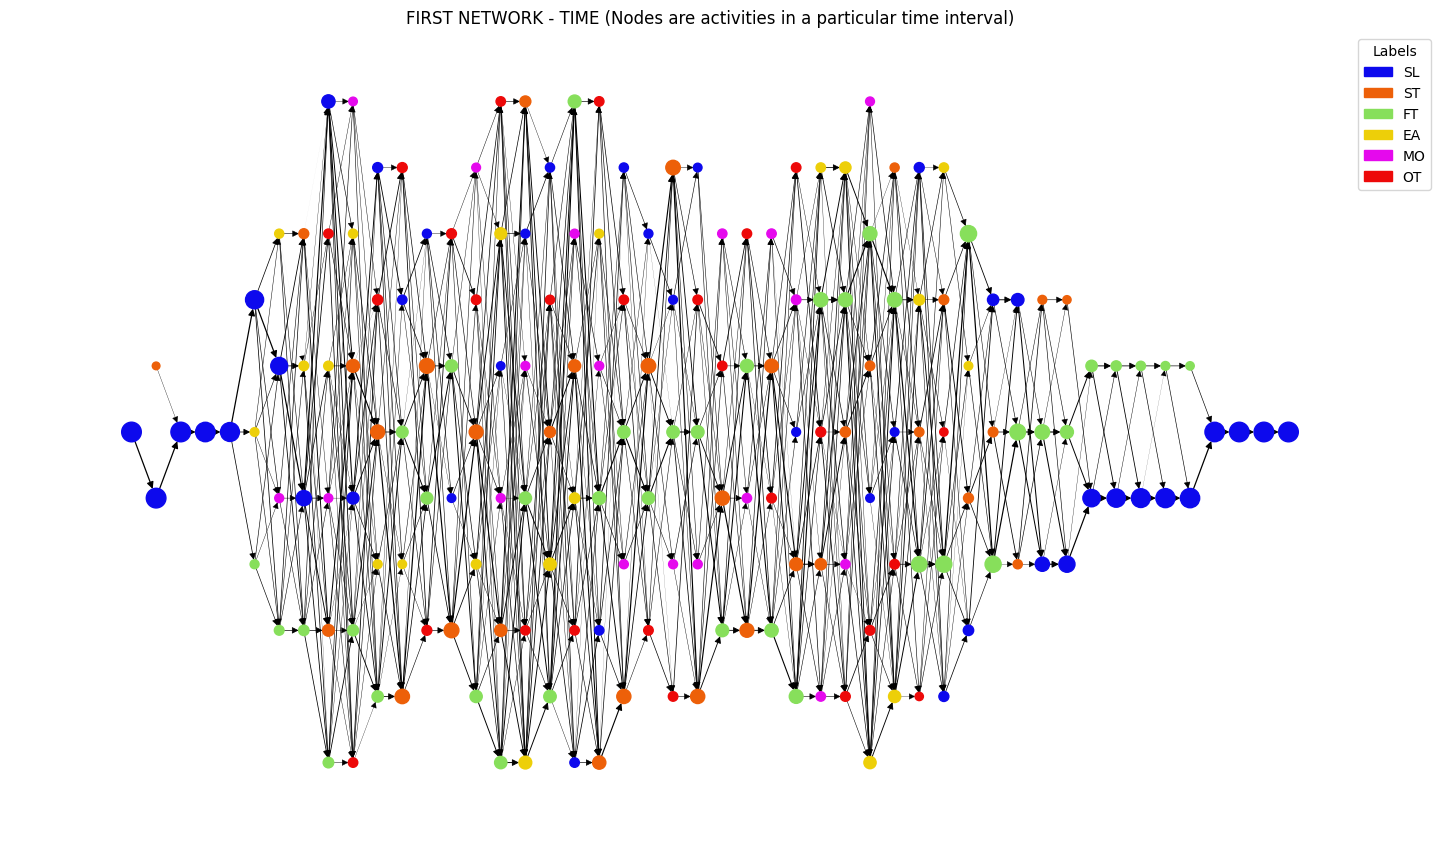

In [16]:
draw_network(G1, title='FIRST NETWORK - TIME (Nodes are activities in a particular time interval)',
             single_subject=False, figsize=(14, 8))

### Transitions

<img src="images/transitions.png" alt= “” width=70% height=70%>

**Function: sequences_by_transitions**

`sequences_by_transitions(dataframe, categories='all', start='05:00:00', end='04:30:00')`

The `sequences_by_transitions` function extracts sequences of transitions between activities from a given dataframe. It starts the sequences at the same point in time and allows for modification of the activity column for improved detection of transitions.

**Parameters**
- `dataframe` (Pandas DataFrame): the input dataframe containing the data from which transitions will be extracted. It must have the following columns: 'id', 'datetime', 'year', 'what', 'where', 'withw', 'mood'.
- `categories` (str or dict, default: `'all'`): specifies the categories to consider for encoding. By default, it considers all activities. If set to 'general', the 'what' column will be modified. Alternatively, you can provide a dictionary mapping between activities and their preferred encoding. If a dictionary is provided, the values must be strings of length 2.
- `start` (str, optional): the starting time for the sequences. The default value is '05:00:00'.
- `end` (str, optional): the ending time for the sequences. The default value is '04:30:00'.

**Output**

`df_result_final` (DataFrame), containing two columns: 'what_code' and 'what_next_code'. These columns represent the network edgelist from which the transitions are extracted.

**Notes**:

- The function assumes that the input dataframe has the necessary columns. If the columns are missing, an error will be raised.
- The function utilizes several helper functions: `encoding`, `align_sequences`, and `modify_what`. These functions are called internally to perform certain operations.

In [17]:
transitions = sequences_by_transitions(df2, categories=categories)
transitions

,id,what,start,end,year,sequence_day,transition,what_code,what_next_code
0,0,Sleeping,2020-11-14 05:00:00,2020-11-14 08:00:00,2020,2020-11-14,1,1SL,2OT
1,0,Other,2020-11-14 08:00:00,2020-11-14 09:00:00,2020,2020-11-14,2,2OT,3EA
2,0,Eating,2020-11-14 09:00:00,2020-11-14 09:30:00,2020,2020-11-14,3,3EA,4MO
3,0,Moving,2020-11-14 09:30:00,2020-11-14 11:30:00,2020,2020-11-14,4,4MO,5FT
4,0,Free Time,2020-11-14 11:30:00,2020-11-14 12:00:00,2020,2020-11-14,5,5FT,6MO
...,...,...,...,...,...,...,...,...,...
49324,246,Other,2018-05-22 20:30:00,2018-05-22 21:00:00,2018,2018-05-22,10,10OT,11MO
49325,246,Moving,2018-05-22 21:00:00,2018-05-22 21:30:00,2018,2018-05-22,11,11MO,12FT
49326,246,Free Time,2018-05-22 21:30:00,2018-05-22 23:30:00,2018,2018-05-22,12,12FT,13OT
49327,246,Other,2018-05-22 23:30:00,2018-05-23 00:00:00,2018,2018-05-22,13,13OT,14SL


In [18]:
transitions.to_csv('transitions.csv', index=False)

In [19]:
G2, edgelist2 = create_network(df=transitions,
                               what_column='what_code',
                               what_next_column='what_next_code',
                               categories=categories,
                               node_degree_filter=None,  # [10,300]
                               edge_weight_filter=50,
                               rescale_node_size=True,
                               weekdays=True,
                               random_subject=False,
                               edgelist_to_csv='edgelist2.csv',
                               network_type=2)

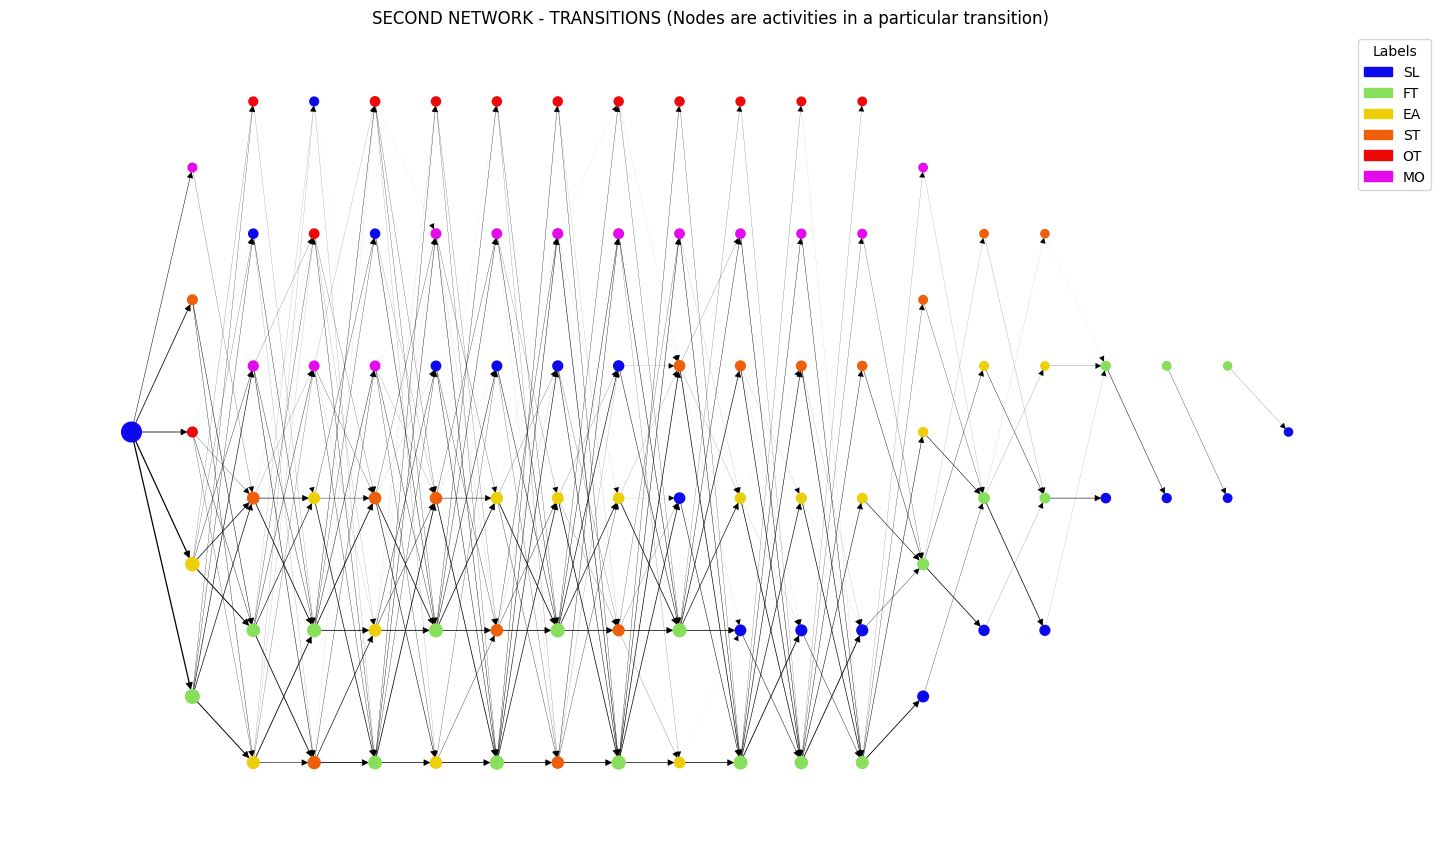

In [20]:
draw_network(G2, title='SECOND NETWORK - TRANSITIONS (Nodes are activities in a particular transition)',
             figsize=(14, 8), single_subject=False)

### Time and Transitions

<img src="images/time_transitions.png" alt= “” width=70% height=70%>

**Function `time_and_transitions`**

`time_and_transitions(dataframe, categories='all', start='05:00:00', end='04:30:00')`

The `time_and_transitions` function takes a dataframe as input and extracts sequences from it based on time intervals. It also encodes activities and detects transitions between them. The function returns a dataframe with additional columns `['what_code', 'what_next_code']` that encode activities and capture transitions between time intervals.

**Parameters**

- `dataframe` (pandas DataFrame): The input dataframe from which sequences are extracted. The dataframe must have at least the following columns: `'id', 'datetime', 'year', 'what', 'where', 'withw', 'mood'`.

- `categories` (str or dict, default: `'all'`): The parameter to specify the categories for encoding. It accepts strings `'all'` and `'general'`, or a dictionary mapping between activities and preferred encodings. If a dictionary is provided, the values in the dictionary must be strings of length 2.

- `start` (str, default: `'05:00:00'`): The start time of the time interval. It represents the first time interval.

- `end` (str, default: `'04:30:00'`): The end time of the time interval. It represents the last time interval.

**Output**

The function returns a dataframe with added columns `['what_code', 'what_next_code']` that encode each activity based on the time interval and capture transitions between activities.

*Please note that the function relies on other helper or processing functions (encoding, sequences_by_transitions, and time_encoding)*.

In [21]:
time_transitions = time_and_transitions(df2, categories=categories)
time_transitions

,id,what,start,end,year,sequence_day,transition,time_interval,what_code,what_next_code
0,0,Sleeping,2020-11-14 05:00:00,2020-11-14 08:00:00,2020,2020-11-14,1,1,1SL,7OT
1,0,Other,2020-11-14 08:00:00,2020-11-14 09:00:00,2020,2020-11-14,2,7,7OT,9EA
2,0,Eating,2020-11-14 09:00:00,2020-11-14 09:30:00,2020,2020-11-14,3,9,9EA,10MO
3,0,Moving,2020-11-14 09:30:00,2020-11-14 11:30:00,2020,2020-11-14,4,10,10MO,14FT
4,0,Free Time,2020-11-14 11:30:00,2020-11-14 12:00:00,2020,2020-11-14,5,14,14FT,15MO
...,...,...,...,...,...,...,...,...,...,...
49324,246,Other,2018-05-22 20:30:00,2018-05-22 21:00:00,2018,2018-05-22,10,32,32OT,33MO
49325,246,Moving,2018-05-22 21:00:00,2018-05-22 21:30:00,2018,2018-05-22,11,33,33MO,34FT
49326,246,Free Time,2018-05-22 21:30:00,2018-05-22 23:30:00,2018,2018-05-22,12,34,34FT,38OT
49327,246,Other,2018-05-22 23:30:00,2018-05-23 00:00:00,2018,2018-05-22,13,38,38OT,39SL


In [22]:
time_transitions.to_csv('time_transitions.csv', index=False)

In [23]:
G3, edgelist3 = create_network(df=time_transitions,
                               what_column='what_code',
                               what_next_column='what_next_code',
                               categories=categories,
                               node_degree_filter=None,
                               edge_weight_filter=50,
                               rescale_node_size=True,
                               weekdays=True,
                               random_subject=False,
                               edgelist_to_csv='edgelist3.csv', 
                               network_type = 3)

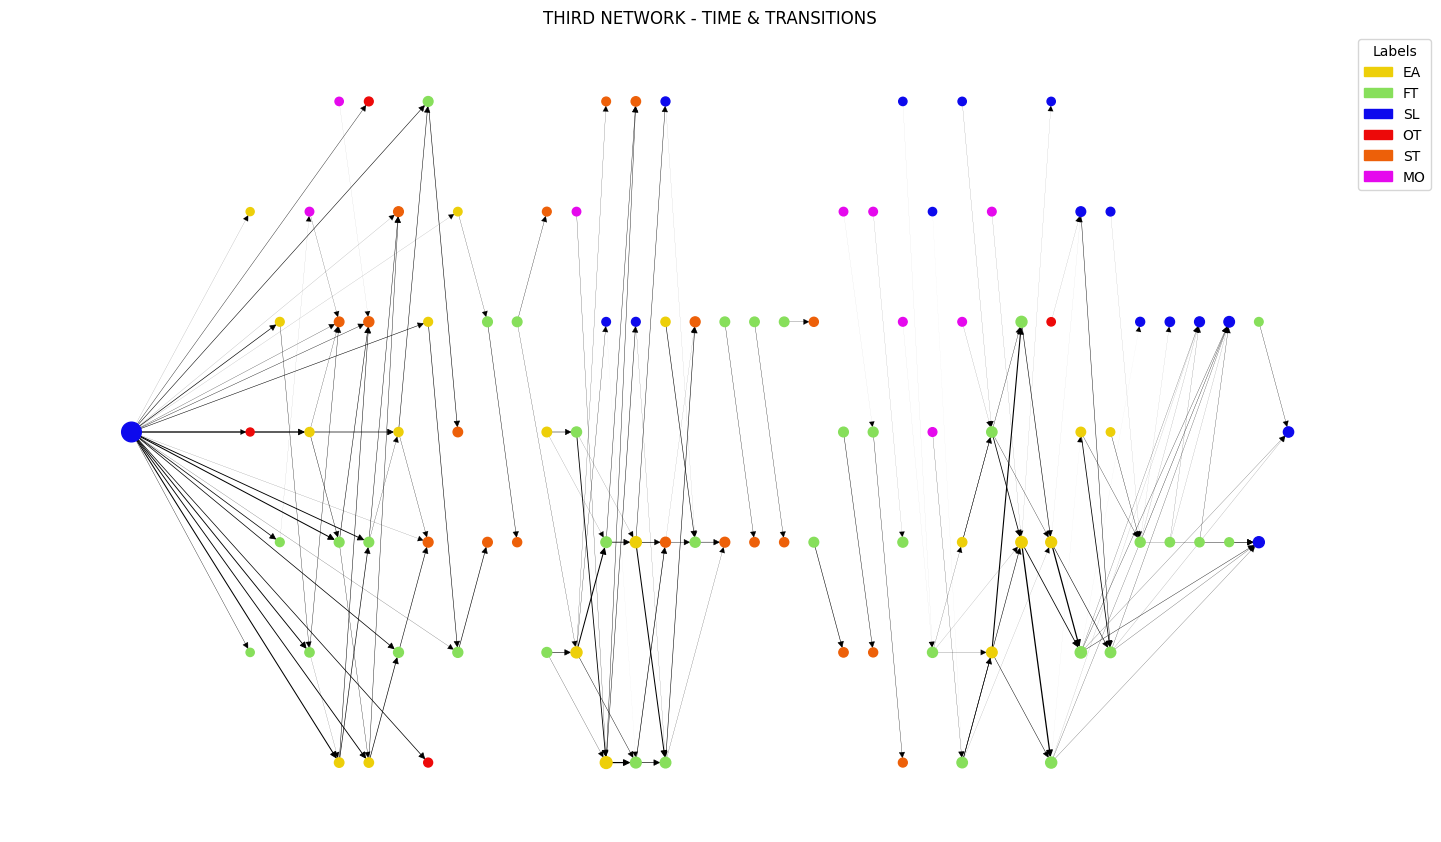

In [24]:
draw_network(G3, title='THIRD NETWORK - TIME & TRANSITIONS', single_subject=False, figsize=(14, 8))

In [25]:
# Check if there are connections between nodes of the same type in the last network

edgelist3['source_letters'] = edgelist3['source'].str.extract('([A-Z]+)')
edgelist3['target_letters'] = edgelist3['target'].str.extract('([A-Z]+)')

if len(edgelist3[edgelist3['source_letters'] == edgelist3['target_letters']]) == 0:
    print('There are no connections between nodes of the same type.')
else:
    print('There is some error in the code :(')

There are no connections between nodes of the same type.


## 3. Visualize networks for single subject

In [ ]:
## WEEKDAYS

# set ID or select randomly
# n_id = int(info['id'].sample())
# n_id = 29

# params = {'what_column': 'what_code',
#           'what_next_column': 'what_next_code',
#           'categories': categories,
#           'weekdays': True,
#           'random_subject': n_id,
#           'node_degree_filter':[10, 0]}

# Time intervals
# G1_s, counts_s, color_dict = create_network(df=time_intervals, return_color_dict=True, network_type=1, **params)

# Transitions
# params['color_dict'] = color_dict
# G2_s, counts2_s = create_network(df=transitions,network_type=2, **params)

# # Time and Transitions
# G3_s, counts3_s = create_network(df=time_transitions, network_type=3, **params)

# draw_all_networks([G1_s, G2_s, G3_s], single_subject=True, figsize=(20, 15))

# # Check if it is a Directed Acyclic Graph (DAG)
# print('Is Time Intervals Network a Directed Acyclic Graph (DAG)?       ', nx.is_directed_acyclic_graph(G1_s))
# print('Is Transitions Network a Directed Acyclic Graph (DAG)?          ', nx.is_directed_acyclic_graph(G2_s))
# print('Is Time and Transition Network a Directed Acyclic Graph (DAG)?  ', nx.is_directed_acyclic_graph(G3_s))

##################################################################################################################

# set ID or select randomly
n_id = int(info['id'].sample())
#n_id = numero

params = {'what_column': 'what_code',
          'what_next_column': 'what_next_code',
          'categories': categories,
          'weekdays': True,
          'random_subject': n_id,
          'edge_weight_filter':0}

# Time intervals
G1_s, counts_s, color_dict = create_network(df=time_intervals, return_color_dict=True, network_type=1, **params)

# Transitions
params['color_dict'] = color_dict
G2_s, counts2_s = create_network(df=transitions, network_type=2, **params)

# Time and Transitions
G3_s, counts3_s = create_network(df=time_transitions,  network_type=3, **params)

print('Subject ID:', n_id)
draw_all_networks([G1_s, G2_s, G3_s], single_subject=True, figsize=(20, 15))

# Check if it is a Directed Acyclic Graph (DAG)
print('Is Time Intervals Network a Directed Acyclic Graph (DAG)?       ', nx.is_directed_acyclic_graph(G1_s))
print('Is Transitions Network a Directed Acyclic Graph (DAG)?          ', nx.is_directed_acyclic_graph(G2_s))
print('Is Time and Transition Network a Directed Acyclic Graph (DAG)?  ', nx.is_directed_acyclic_graph(G3_s))

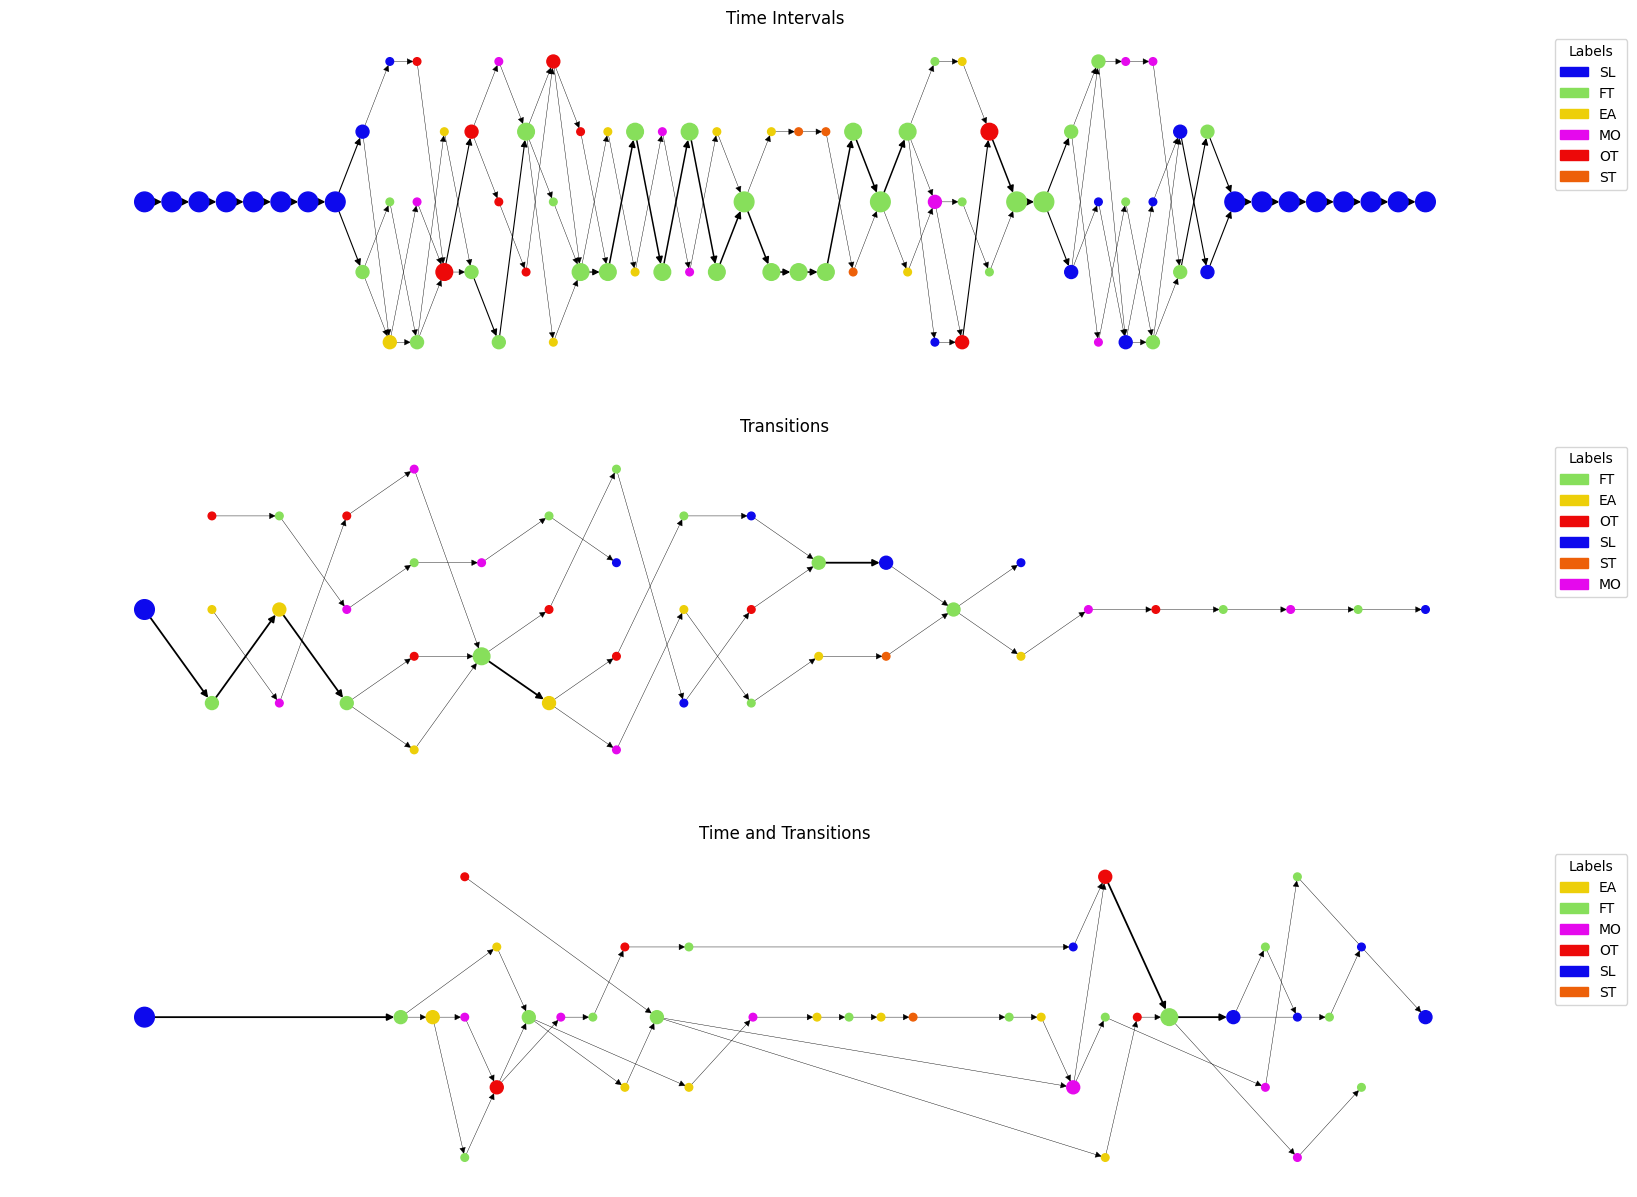

Is Time Intervals Network a Directed Acyclic Graph (DAG)?        True
Is Transitions Network a Directed Acyclic Graph (DAG)?           True
Is Time and Transition Network a Directed Acyclic Graph (DAG)?   True


In [ ]:
### WEEKEND FOR THE SAME SUBJECT

params = {'what_column': 'what_code',
          'what_next_column': 'what_next_code',
          'categories': 'all',
          'weekdays': False,
          'random_subject': n_id,
          'color_dict':color_dict,
          'edge_weight_filter':0}

# Time intervals
G1_s, counts_s = create_network(df=time_intervals, **params, network_type=1)

# # Transitions
G2_s, counts2_s = create_network(df=transitions, network_type=2, **params)

# # Time and Transitions
G3_s, counts3_s = create_network(df=time_transitions, network_type=3, **params)

draw_all_networks([G1_s, G2_s, G3_s], single_subject=True, figsize=(20, 15))

# Check if it is a Directed Acyclic Graph (DAG)
print('Is Time Intervals Network a Directed Acyclic Graph (DAG)?       ', nx.is_directed_acyclic_graph(G1_s))
print('Is Transitions Network a Directed Acyclic Graph (DAG)?          ', nx.is_directed_acyclic_graph(G2_s))
print('Is Time and Transition Network a Directed Acyclic Graph (DAG)?  ', nx.is_directed_acyclic_graph(G3_s))

In [ ]:
# Check if there are connections between nodes of the same type in the last network

counts3_s['source_letters'] = counts3_s['source'].str.extract('([A-Z]+)')
counts3_s['target_letters'] = counts3_s['target'].str.extract('([A-Z]+)')


if len(counts3_s[counts3_s['source_letters'] == counts3_s['target_letters']]) == 0:
    print('There are no connections between nodes of the same type.')
else:
    print('There is some error in the code :(')

There are no connections between nodes of the same type.
